In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# from astropy.io import fits
# import lightkurve as lk
# from astropy import units as u
# from astropy.coordinates import SkyCoord
# import pickle
# from sys import argv
# import sys
# from astroquery.mast import Observations
# from astroquery.mast import Catalogs
%matplotlib inline
from plot_cdips_2 import *
from scipy.ndimage import gaussian_filter1d
import scipy
from ipywidgets import interact, widget
import ipywidgets as widgets
from uncertainties import ufloat 
from tools import findPeaks2, findPeaks



font = {'weight' : 'normal',
# 'family' : 'normal',
'size'   : 14}
plt.rc('font', **font)
plt.rc('figure', figsize=(12, 8))
plt.rc('axes', grid=True)
plt.rc('lines', markersize=10)


In [83]:
ids_to_get = [
    196515469, 
#     130439989, 
    175182193,
#     285215256,
]

fts = get_cdips_product(ids_to_get)

Filtered down to 490 items to index from.
TIC ['196515469', '175182193'] returned 3 object(s).
After removing duplicates, 2 object(s) remain.
INFO: Found cached file ./mastDownload\HLSP\hlsp_cdips_tess_ffi_gaiatwo0005586882605263172608-0007-cam3-ccd1_tess_v01_llc\hlsp_cdips_tess_ffi_gaiatwo0005586882605263172608-0007-cam3-ccd1_tess_v01_llc.fits with expected size 334080. [astroquery.query]
INFO: Found cached file ./mastDownload\HLSP\hlsp_cdips_tess_ffi_gaiatwo0005646988748426465536-0008-cam2-ccd1_tess_v01_llc\hlsp_cdips_tess_ffi_gaiatwo0005646988748426465536-0008-cam2-ccd1_tess_v01_llc.fits with expected size 276480. [astroquery.query]
Done.


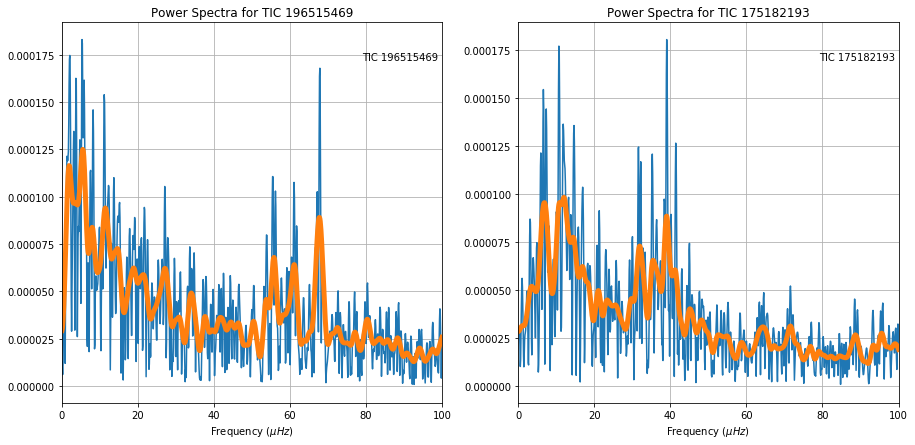

In [91]:
freq_windows = [
  # (min freq, dnu, num folds)
    (30, 6.2, 10),
#     (10, 2, 10),
    (20, 4, 10),
#     (8, 5, 16)
]


ft0 = fts[0]
# print("Analysing TIC", ft0.ticid)
lc_pca = [
    f.get_lc('pca', ap=3, clip=2) for f in fts
]
pg_pca = [
    lc.to_periodogram(freq_unit=u.microhertz) for lc in lc_pca
]
n = len(fts)
nrows = (n+1)//2
ncols = min(n, 2)
fig = plt.figure(figsize=(15, 7*nrows))
axes = fig.subplots(ncols=ncols, nrows=nrows).flatten()

for (ax, pg, f) in zip(axes, pg_pca, fts):
    ax.plot(pg.frequency, pg.power)
    ax.plot(pg.frequency, gaussian_filter1d(pg.power, 6), linewidth=5)
    ax.set_xlim(0, 100)
    ax.set_xlabel(r"Frequency $(\mu Hz)$")
    ax.set_title(f"Power Spectra for TIC {f.ticid}")
    ax.annotate(f"TIC {f.ticid}", xy=(0.99, 0.90), xycoords='axes fraction', ha='right')

plt.show()
# plt.plot(pg_pca.frequency, pg_pca.power)
# xax = np.linspace(0, 250, 5000)
# plt.plot(xax, np.interp(xax, freq, powr, ))
# plt.xlim(0, 50)

Folded region


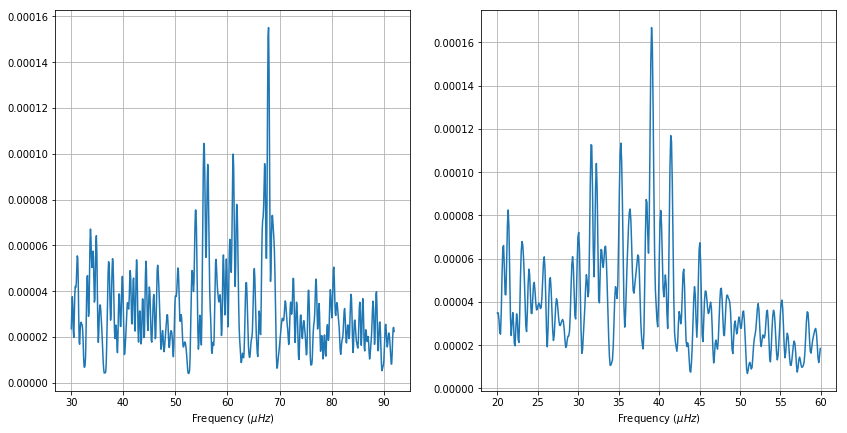

In [90]:
fig = plt.figure(figsize=(14, 7*nrows))
axes = fig.subplots(nrows=nrows, ncols=ncols).flatten()
print("Folded region")
for i in range(n):    
    ax = axes[i]
    min_freq, dnu, num_windows = freq_windows[i]
    pg = pg_pca[i]
    freq = pg.frequency
    powr = pg.power
    ax.set_xlabel(r"Frequency $(\mu Hz)$")
    mask = freq.value > min_freq
    freq_ax = freq[mask]
    powr_ax = powr[mask]
    mask = freq_ax.value < min_freq + num_windows*dnu
    freq_ax = freq_ax[mask]
    powr_ax = powr_ax[mask]
    ax.plot(freq_ax, gaussian_filter1d(powr_ax, 1))

In [88]:

def dnu_fold(dnu, ax=0):
    'returns: means (1d), folded and windows (both 2d)'
    min_freq, _, num_windows = freq_windows[ax]
    pg = pg_pca[ax]
    freq = pg.frequency
    powr = pg.power
    
    windows = (
        np.linspace(0, dnu, 500).reshape(1, -1) +
        ((np.arange(num_windows) * dnu).reshape(-1, 1) + min_freq)
    )
    folded = np.interp(windows, freq, gaussian_filter1d(powr, 1))
    mean = np.mean(folded, axis=0)
    return mean, folded, windows

i = 0
for ((min_freq, dnu, num_windows), pg, f) in zip(freq_windows, pg_pca, fts):
    fig = plt.figure(figsize=(5, 7))
#     ax = fig.gca()
    @interact(dnu=widgets.FloatSlider(dnu, min=max(dnu-1.4, 0.1), max=dnu+1.5, step=0.01), i=widgets.fixed(i))
    def plot_fold(dnu, i=0):
        global h
#         print(i)
#         plt.matshow((dnu_fold(dnu)[1].shape), aspect='auto')
        
        mean, folded, windows = dnu_fold(dnu, ax=i)
        tiled = np.tile(folded, (2, 1, 1))
        tiled[1] = np.roll(tiled[1], -1, axis=0)
        _ = plt.matshow(np.concatenate(
            tiled, axis=1), aspect='auto')
        print(dnu)
        plt.show()
    
    i += 1

plt.show()

#     fig = plt.figure(figsize=(14, 5))
# #     ax = fig.
#     fig.




<Figure size 360x504 with 0 Axes>

interactive(children=(FloatSlider(value=6.2, description='dnu', max=7.7, min=4.800000000000001, step=0.01), Ou…

<Figure size 360x504 with 0 Axes>

interactive(children=(FloatSlider(value=4.0, description='dnu', max=5.5, min=2.6, step=0.01), Output()), _dom_…

TIC 196515469
   below: [3.13723724 3.7981982  4.21711712 4.46846847 4.71051051 4.86876877
 6.18138138]
   above: [ 6.26516517  6.72132132  7.2984985   7.6987988   7.94084084  8.34114114
  8.68558559  9.15105105  9.96096096 10.19369369 11.03153153 11.33873874]
TIC 175182193
   below: [2.3003003  2.52252252 2.62462462 3.06306306 3.37537538 3.63963964
 3.99399399]
   above: [4.16216216 4.40840841 4.6006006  4.85885886 5.40540541 6.04204204
 6.34234234 6.66066066 7.48948949 7.70570571]


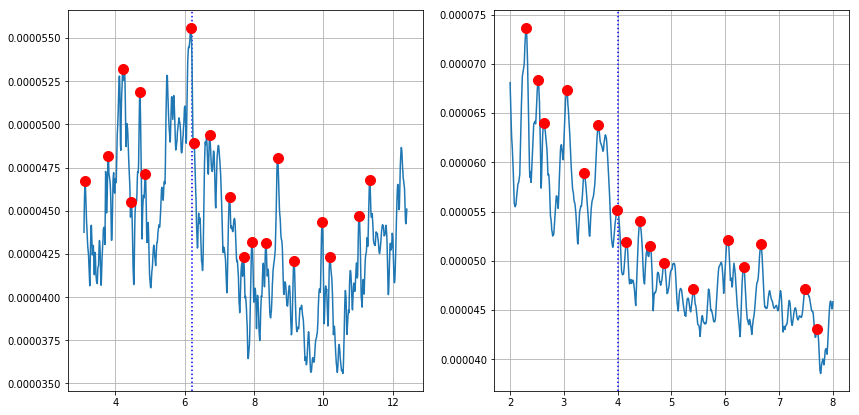

In [94]:
fig = plt.figure(figsize=(14, 7*nrows))
axes = fig.subplots(nrows=nrows, ncols=ncols).flatten()
for i in range(n):
    min_freq, dnu, num_windows = freq_windows[i]
    ax = axes[i]
    dnu_ax = np.linspace(dnu/2, dnu*2, 1000)
    means = np.array([dnu_fold(x, ax=i)[0] for x in dnu_ax])
    pks = np.max(means, axis=1)
    ax.axvline(dnu, linestyle=':', color='b')
    ax.plot(dnu_ax, pks)
    pkpks = findPeaks(pks, thresh_perc=0.9)
    ax.plot(dnu_ax[pkpks], pks[pkpks], 'ro')
    below = dnu_ax[pkpks] < dnu
    print(f"TIC {fts[i].ticid}")
    print("   below:", dnu_ax[pkpks][below])
    print("   above:", dnu_ax[pkpks][~below])

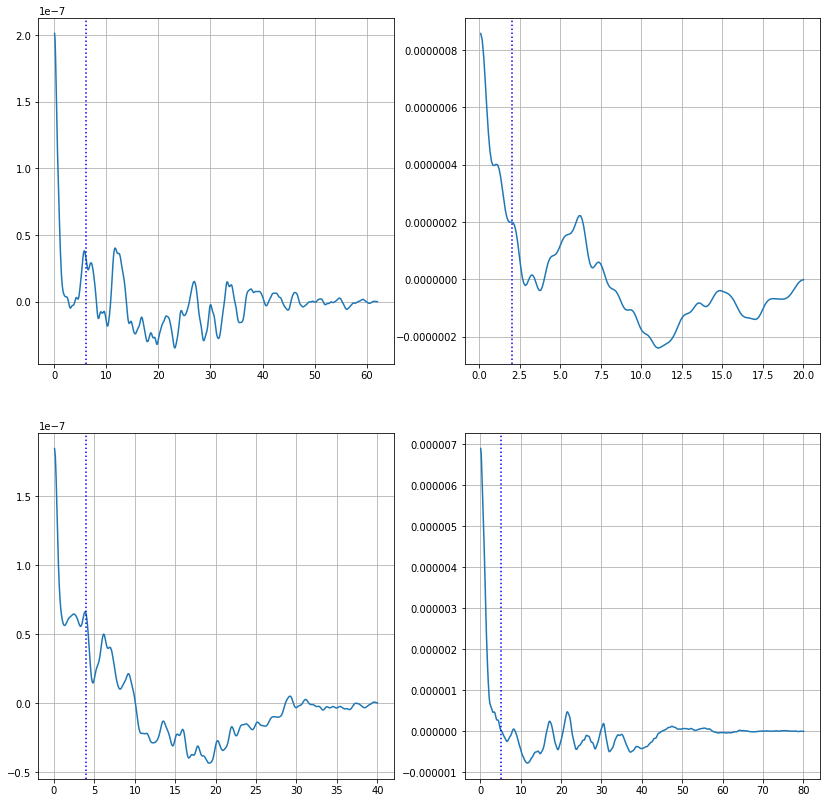

In [82]:
# Determines the autocorrelation of the power
fig = plt.figure(figsize=(14, 7*nrows))
axes = fig.subplots(nrows=nrows, ncols=ncols).flatten()
for i in range(n):
    min_freq, dnu, num_windows = freq_windows[i]
    ax = axes[i]
    pg = pg_pca[i]
    freq = pg.frequency
    powr = pg.power
    mask = freq.value > min_freq
    freq_ax = freq[mask]
    powr_ax = powr[mask]
    mask = freq_ax.value < min_freq + num_windows*dnu
    freq_ax = freq_ax[mask]
    powr_ax = powr_ax[mask]

    n_ax = np.arange(powr_ax.size)
    nl_ax = (n_ax.reshape(-1, 1) - n_ax.reshape(1, -1)).T
    n_ax = np.tile(n_ax.reshape(1, -1), (len(n_ax), 1))
    zeros = np.zeros(nl_ax.shape)
    powr_grid = np.tile(gaussian_filter1d(powr_ax, 2).reshape(1, -1), (len(powr_ax), 1)) - np.mean(powr_ax)
    zeros[nl_ax >= 0] = powr_grid[(nl_ax >=0 )[:,::-1]]

    prod = zeros * powr_grid
    sums = np.sum(prod, axis=1)

# plt.matshow(prod)
# plt.figure()
    ax.plot(freq[:len(freq_ax)], sums)
    ax.axvline(dnu, linestyle=':', color='b')
#     ax.axvline(numax, linestyle=':', color='b')
plt.show()

In [41]:
print("Initial dnus:")
for i in range(n):
    print(f"TIC {fts[i].ticid:>9}: {freq_windows[i][1]} uHz")

Initial dnus:
TIC 196515469: 6.2 uHz
TIC 130439989: 2 uHz
TIC 175182193: 4 uHz


## Mass and Radius Calculation
$$
    M = \left(\nu_{max}^3 / \Delta \nu^4 \right) T^{1.5} \\
    R = \left(\nu_{max} / \Delta \nu^2 \right) T^{1/2}
$$

In [96]:
finals = [
    # numax, dnu
    (ufloat(57, 2), ufloat(6.2, 0.3)),
#     (ufloat(15, 1), ufloat(2.08, 0.02)),
    (ufloat(37, 2), ufloat(3.72, 0.3)),
#     (ufloat(37, 5), ufloat(3.72, 0.5)),
]

numax_sol = 3100
dnu_sol = 134.8
T_sol = 5777

for i in range(n):
    f = fts[i]
    print(f"Final values for TIC {f.ticid}:")
    numax_u, dnu_u = finals[i]
    T_u = ufloat(f.Teff, 50)
    print(f"    nu_max  = {numax_u.n} +/- {numax_u.s} uHz [Expected dnu of {0.262*numax_u**.772:.2f}]")
    print(f"    dnu     = {dnu_u.n} +/- {dnu_u.s} uHz")
    print(f"    T_eff   = {T_u.n:.2f} +/- {T_u.s} K")
    
    numax_u /= numax_sol
    dnu_u /= dnu_sol
    T_u /= T_sol
    M_u = (numax_u**3 / dnu_u**4) * T_u**1.5
    R_u = (numax_u / dnu_u**2) * T_u**0.5
    print("  Results:")
    print(f"    M/M_sol = {M_u.n:.3f} +/- {M_u.s:.3f}")
    print(f"    R/R_sol = {R_u.n:.3f} +/- {R_u.s:.3f}")
    print()



Final values for TIC 196515469:
    nu_max  = 57.0 +/- 2.0 uHz [Expected dnu of 5.94+/-0.16]
    dnu     = 6.2 +/- 0.3 uHz
    T_eff   = 4796.19 +/- 50.0 K
  Results:
    M/M_sol = 1.051 +/- 0.232
    R/R_sol = 7.920 +/- 0.816

Final values for TIC 175182193:
    nu_max  = 37.0 +/- 2.0 uHz [Expected dnu of 4.26+/-0.18]
    dnu     = 3.72 +/- 0.3 uHz
    T_eff   = 4660.10 +/- 50.0 K
  Results:
    M/M_sol = 2.124 +/- 0.768
    R/R_sol = 14.076 +/- 2.396



In [ ]:
table_data[]